# Assignment 4: Movie Review Analysis [50 Pt]

In this assignment, we will build a recurrent neural network to work with sequential text data, specificially, movie review data to identify the reviewer sentiment. In the process of completing this assignment, you will:
    
1. Clean and process text data for machine learning.
2. Perform tokenization of text data.
3. Understand and implement a word-level recurrent neural network.
4. Implement batching of text data using a DataLoader before training a recurrent neural network.
5. Understand how to apply pretrained models for transfer learning in natural language processing projects.

## Colab Link

Include a link to your Colab file here. If you would like the TA to look at your Colab file in case your solutions are cut off, **please make sure that your Colab file is publicly accessible at the time of submission.**

In [ ]:
# TO BE COMPLETED

#https://colab.research.google.com/drive/1c1efSJ0sW2WpCBl3RbHALoN6yV5TrzmK?usp=sharing

# PART A - Sentiment Analysis

In this part we will construct a world-level LSTM model for identifying positive and negative reviews. This will be done in a similar way to what was shared in the preparation code for Assignment 4.

In [ ]:
# load standard modules/libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

# load special modules/libraries
import os
import warnings
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

from collections import Counter
import string
import re
from tqdm  import tqdm

# load pytorch modules/libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset,DataLoader

import torchtext
import random

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## Part 1. Data Cleaning [5 pt]

We will be using the "IMDB Movie Review Dataset" provided on the course website. Download "IMDB Dataset.csv" into your Colab workspace.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Part (i) [1pt EXPLORATORY]

Open up the file in Python, and examine some examples of positive and negative reviews. Comment on the quality of the data and any challenges you foresee in working with these data. Pick one example of a positive review and one of a negative review to support your comments.

In [ ]:
# download IMDB review data

# load dataset
df = pd.read_csv(filepath_or_buffer='/content/drive/MyDrive/Colab Notebooks/MIE1517/IMDB Dataset.csv')

# process into data and labels
X = df['review'].values
y = df['sentiment'].values

print(X.shape,y.shape)

(50000,) (50000,)


In [ ]:
# TO BE COMPLETED
print(X[:5])
print(y[:5])

["One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the f

In [ ]:
'''
PROVIDE YOUR ANSWER BELOW

Positive Example:

  'A wonderful little production. <br /><br />The filming technique is very unassuming........
  ......with Halliwell\'s murals decorating every surface) are terribly well done.'

  The above example used a lot of expressive words such as wonderful,terrifically and masterful as
  a clear sign of positive sentiment. The review is fine detailed that described the film through
  a lot of aspects.

Negative Example:
  'One of the other reviewers has mentioned that after watching.....................
  ........thats if you can get in touch with your darker side.'

  This reviewer of this example stated that the scenes of violence is brutal and unflinch. In additon,
  reviewer also describe this moive as a hardcore which clearly shows a negative sentiment.

In conclusion,the data provided consist of detailed reviews on a various kind of TV series and films
with the corresponding sentiment response. After examing the data, some reviews were found to
contain unexpected character such as HTML tags ("<br/><br/>") and backslash ("\").

'''


### Part (ii) [1pt EXPLORATORY]

Perform summary statistics on the dataset. What is the average character length of a review? What are the lengths of the longest and shortest reviews?

How many positive reviews and negative reviews are there. Generate a histogram to compare the average character length for positive and negative reviews. Comment on the differences in positive and negative reviews and how that may affect the model you will be using later.

Average Review Length: 1309.43102
Longest Review Length: 13704
Shortest Review Length: 32
Number of Positive Reviews: 25000
Number of Negative Reviews: 25000


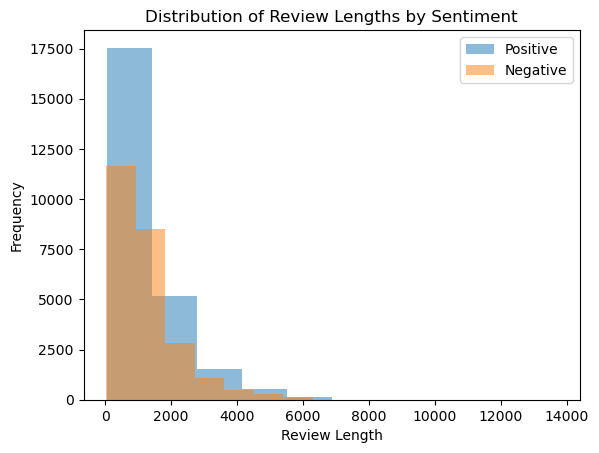

In [ ]:
# TO BE COMPLETED

# Add a new column for review lengths
df['review_length'] = df['review'].apply(len)

# Calculate summary statistics
avg_length = df['review_length'].mean()
max_length = df['review_length'].max()
min_length = df['review_length'].min()

# Count positive and negative reviews
positive_count = len(df[df['sentiment'] == 'positive'])
negative_count = len(df[df['sentiment'] == 'negative'])

# Display summary statistics
print("Average Review Length:", avg_length)
print("Longest Review Length:", max_length)
print("Shortest Review Length:", min_length)
print("Number of Positive Reviews:", positive_count)
print("Number of Negative Reviews:", negative_count)

# Generate a histogram
plt.hist(df[df['sentiment'] == 'positive']['review_length'], alpha=0.5, label='Positive')
plt.hist(df[df['sentiment'] == 'negative']['review_length'], alpha=0.5, label='Negative')
plt.title('Distribution of Review Lengths by Sentiment')
plt.xlabel('Review Length')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.show()





In [ ]:
'''
PROVIDE YOUR ANSWER BELOW

General observations :
                      1.Average Review Length: 1309.43102
                      2.Longest Review Length: 13704
                      3.Shortest Review Length: 32
                      4.Number of Positive Reviews: 25000
                      5.Number of Negative Reviews: 25000


Observations positive vs negative:
                      According to the historgram, it can be seen that the negative review have relativley
                      longer length than the positive reviews. Then, the model will associate the length
                      of review with the output of sentiment eventually.


'''


### Part (iii) [1pt EXPLORATORY]

The following helper code will be used to process the data before we can train our LSTM model. In point form comment on what processing steps are performed in the code provided below and why these steps are necessary or beneficial to training and LSTM.

In [ ]:
X[0]

"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fa

In [ ]:
def preprocess_string(str1):
    # remove all non-word characters excluding number and letters
    str1= re.sub(r"[^\w\s]",'',str1)
    # remove all whitespace with no space
    str1= re.sub(r"\s",'',str1)
    # replace digits with no space
    str1= re.sub(r"\d",'',str1)
    return str1

def preprocess_sentence(sen1):
    word_list=[]
    stop_word = set(stopwords.words("english"))
    for word in sen1.lower().split():
        word = preprocess_string(word)
        if word not in stop_word and word!='':
            word_list.append(word)
    return word_list

def get_stoi(data):
    word_list=[]
    for review in data:
        word_list.extend(preprocess_sentence(review))
    corpus = Counter(word_list)
    print(corpus.get)
    # sorting on the basis of most common words
    corpus_ =sorted(corpus,key= corpus.get,reverse=True)[:1000]
    # creating a dict
    stoi =  {ch:i+1 for i,ch in enumerate(corpus_)}
    return stoi

def tokenize(data, labels, stoi):
    # tokenize
    data_encoded = []
    for review in data:
        data_encoded.append([stoi[word] for word in preprocess_sentence(review)
                                     if word in stoi.keys()])

    labels_encoded = [1 if label =='positive' else 0 for label in labels]

    return data_encoded, labels_encoded

def padding_(sentences, seq_len):
    features = np.zeros((len(sentences), seq_len),dtype=int)
    for ii, review in enumerate(sentences):
        if len(review)!=0:
            features[ii, -len(review):] = np.array(review)[:seq_len]

    return features

In [ ]:
'''
PROVIDE YOUR ANSWER BELOW
1. preprocess_string
  -Remove all non-word related-character, white space between words and digits.
  -This function is an essential step in data cleaning that removes uneccessary information from a text file

2. preprocess_sentence
  -Process sentence with preprocess_string func and remove sentence stop conditions (stop words or space)
  -This function eliminate extra noise from the text data which further cleaned the dataset.

3. get_stoi
  -Set up a counter to count the frequency of each words appeared in the datasets. Then, choose the top 1000
  words and build a 'stoi' which assign each frequent words to a integer.
  -This function build a 'stoi' which create a list of vocabulary with a unique integer for this datasets. A
  'stoi' will simplify the input space and greatly increase the traning process of LSTM

4. tokenize
  -Encode the data based on the integer number in 'stoi'. Then, encode labels as 1 for 'positive' and 0
  for 'negative'
  -This function convert text data into integer numbers which is the correct data input format for LSTM model

5. padding
  -Add padding to ensure the length of sequence is the same.
  -This function ensures all input sequence is uniform for LSTM model

'''


### Part (iv) [1pt EXPLORATORY]

Split the dataset into `train`, `valid`, and `test`. Use a 60-20-20 split. Then apply the above processing steps to prepare your data for training.

Set the padding of the reviews to 500.

In [ ]:
# TO BE COMPLETED

# Step 1: Split the dataset
train_data, temp_data, train_labels, temp_labels = train_test_split(X, y, test_size=0.4, random_state=0)
valid_data, test_data, valid_labels, test_labels = train_test_split(temp_data, temp_labels, test_size=0.5, random_state=0)

# Get stoi
stoi = get_stoi(train_data)

# Tokenize
train_data_encoded, train_labels_encoded = tokenize(train_data, train_labels, stoi)
valid_data_encoded, valid_labels_encoded = tokenize(valid_data, valid_labels, stoi)
test_data_encoded, test_labels_encoded = tokenize(test_data, test_labels, stoi)

# Padding
train_data_padded = padding_(train_data_encoded, 500)
valid_data_padded = padding_(valid_data_encoded, 500)
test_data_padded = padding_(test_data_encoded, 500)

# Display the shapes of the processed data
print("Train Data Shape:", train_data_padded.shape)
print("Valid Data Shape:", valid_data_padded.shape)
print("Test Data Shape:", test_data_padded.shape)

<built-in method get of Counter object at 0x0000013433296690>
Train Data Shape: (30000, 500)
Valid Data Shape: (10000, 500)
Test Data Shape: (10000, 500)


In [ ]:
# Function to convert dataset into tensor
from torch.utils.data import Dataset, DataLoader
class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return torch.LongTensor(self.data[idx]), torch.tensor(self.labels[idx], dtype=torch.float32)


In [ ]:
# Create datasets
train_dataset = CustomDataset(train_data_padded, train_labels_encoded)
valid_dataset = CustomDataset(valid_data_padded, valid_labels_encoded)
test_dataset = CustomDataset(test_data_padded, test_labels_encoded)

# Create DataLoader
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Check Frist sample of DataLoader
for batch_idx, (inputs, labels) in enumerate(train_loader):
    print("Batch Index:", batch_idx)
    print("Inputs Shape:", inputs.shape)
    print("Labels Shape:", labels.shape)
    break # Stop

Batch Index: 0
Inputs Shape: torch.Size([16, 500])
Labels Shape: torch.Size([16])


### Part (v) [1pt EXPLORATORY]

Create a DataLoader that will allow you to load the training and validation data in mini-batches. Then generate a dataset of batch size of 16 to verify that the DataLoader works as intended.

## Part 2. Model Building [2pt MODEL]

Build a recurrent neural network model, using an architecture of your choosing. Use one or more fully-connected layers to make the prediction based on your recurrent network output.

Instead of using the RNN output value for the final token, another often used strategy is to max-pool over the entire output array. That is, instead of calling something like:

```
out, _ = self.rnn(x)
self.fc(out[:, -1, :])
```

where `self.rnn` is an `nn.RNN`, `nn.GRU`, or `nn.LSTM` module, and `self.fc` is a
fully-connected
layer, we use:

```
out, _ = self.rnn(x)
self.fc(torch.max(out, dim=1)[0])
```

This works reasonably in practice. An even better alternative is to concatenate the max-pooling and average-pooling of the RNN outputs:

```
out, _ = self.rnn(x)
out = torch.cat([torch.max(out, dim=1)[0],
                 torch.mean(out, dim=1)], dim=1)
self.fc(out)
```

We encourage you to try out all these options. The way you pool the RNN outputs is one of the "hyperparameters" that you can choose to tune later on.

In [ ]:
import torch
import torch.nn as nn

class SentimentRNN(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, output_size, num_layers=1, dropout=0.5):
        super(SentimentRNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(2 * hidden_size, output_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, hidden):
        embedded = self.embedding(x)
        lstm_out, hidden = self.lstm(embedded, hidden)

        # Max-pooling and average-pooling
        max_pool = torch.max(lstm_out, dim=1)[0]
        avg_pool = torch.mean(lstm_out, dim=1)

        # Combine max-pooling and average-pooling
        combined = torch.cat([max_pool, avg_pool], dim=1)
        combined = self.dropout(combined)
        output = self.fc(combined)

        return output, hidden


## Part 3. Training [3 pt]

### Part (i) [1pt MODEL]

Complete the `get_accuracy` function, which will compute the
accuracy (rate) of your model across a dataset (e.g. validation set).

In [ ]:
def get_accuracy(model, data,device):
    """ Compute the accuracy of the `model` across a dataset `data`

    Args:
        model (torch.nn.Module): The PyTorch model.
        data (torch.utils.data.DataLoader): DataLoader containing input and label pairs.

    Returns:
        float: Accuracy of the model on the given dataset.
    """
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in data:
            inputs, labels = inputs.to(device), labels.to(device)
            model = model.to(device)

            outputs, _ = model(inputs, None)
            predictions = torch.round(torch.sigmoid(outputs))

            total += labels.size(0)
            correct += (predictions.squeeze() == labels).sum().item()

    accuracy = correct / total
    return accuracy

### Part (ii) [1pt MODEL]

Train your model. Plot the training curve of your final model.
Your training curve should have the training/validation loss and
accuracy plotted periodically.

In [ ]:
vocab_size = len(stoi) + 1
model = SentimentRNN(vocab_size, 300, 256, 1, 2, 0.5)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
accuracy = get_accuracy(model, valid_loader,device = device)
print(f"Validation Accuracy: {accuracy * 100:.2f}%")

Validation Accuracy: 50.20%


In [ ]:
def train_rnn_network(model, train_loader, valid_loader, num_epochs, learning_rate, device):
    model = model.to(device)

    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    train_losses, valid_losses, train_acc, valid_acc = [], [], [], []
    epochs = []

    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0.0
        # Training loss calculation
        for tweets, labels in train_loader:
            tweets, labels = tweets.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs, _ = model(tweets, None)
            loss = criterion(outputs.squeeze(), labels.float())  # Adjusted here for binary classification
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation loss calculation
        model.eval()
        total_valid_loss = 0.0

        with torch.no_grad():
            for tweets_valid, labels_valid in valid_loader:
                tweets_valid, labels_valid = tweets_valid.to(device), labels_valid.to(device)

                outputs_valid, _ = model(tweets_valid, None)
                loss_valid = criterion(outputs_valid.squeeze(), labels_valid.float())
                total_valid_loss += loss_valid.item()

        avg_valid_loss = total_valid_loss / len(valid_loader)
        valid_losses.append(avg_valid_loss)

        # Accuracy calculation
        model.eval()
        train_accuracy = get_accuracy(model, train_loader, device)
        valid_accuracy = get_accuracy(model, valid_loader, device)

        train_acc.append(train_accuracy)
        valid_acc.append(valid_accuracy)

        epochs.append(epoch)
        print(f"Epoch {epoch+1}/{num_epochs}; Train Loss: {avg_train_loss:.4f}; Valid Loss: {avg_valid_loss:.4f}; Train Acc: {train_accuracy:.4f}; Valid Acc: {valid_accuracy:.4f}")

    # Plotting
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label="Train")
    plt.plot(epochs, valid_losses, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, label="Train")
    plt.plot(epochs, valid_acc, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Training and Validation Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()


Epoch 1/5; Train Loss: 0.5169; Valid Loss: 0.4028; Train Acc: 0.8430; Valid Acc: 0.8195
Epoch 2/5; Train Loss: 0.3663; Valid Loss: 0.3743; Train Acc: 0.8682; Valid Acc: 0.8372
Epoch 3/5; Train Loss: 0.3279; Valid Loss: 0.3636; Train Acc: 0.8831; Valid Acc: 0.8409
Epoch 4/5; Train Loss: 0.2965; Valid Loss: 0.3628; Train Acc: 0.8982; Valid Acc: 0.8448
Epoch 5/5; Train Loss: 0.2729; Valid Loss: 0.3704; Train Acc: 0.9085; Valid Acc: 0.8443


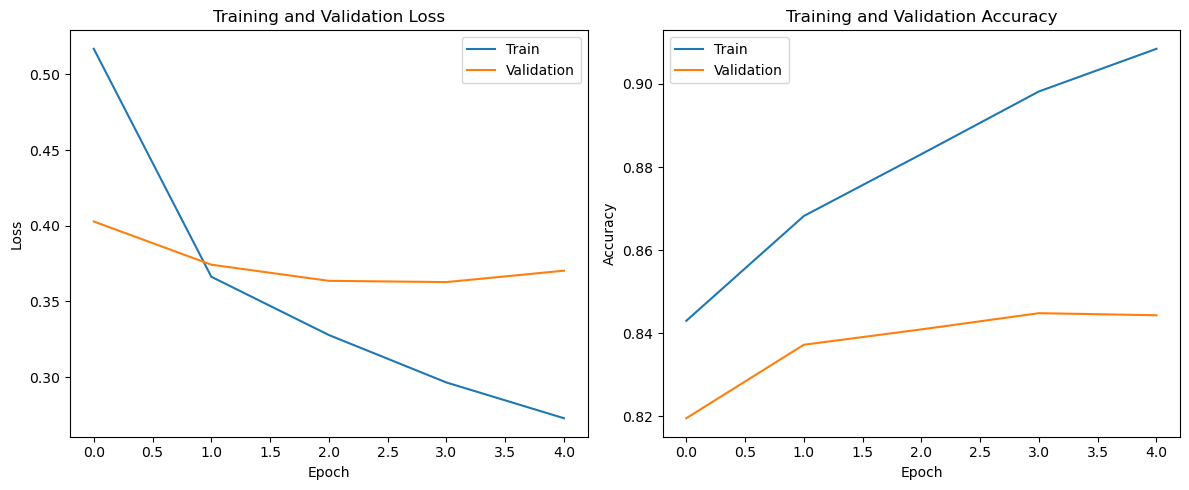

In [ ]:
# Default Training
vocab_size = len(stoi) + 1
model = SentimentRNN(vocab_size, 300, 256, 1, 2, 0.5)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_rnn_network(model, train_loader, valid_loader, num_epochs=5, learning_rate=0.0001, device=device)

### Part (iii) [1pt MODEL]

Choose at least 4 hyperparameters to tune. Explain how you tuned the hyperparameters.
You don't need to include your training curve for every model you trained.
Instead, explain what hyperparemters you tuned, what the best validation accuracy was,
and the reasoning behind the hyperparameter decisions you made.

For this assignment, you should tune more than just your learning rate and epoch.
Choose at least 2 hyperparameters that are unrelated to the optimizer.

Epoch 1/5; Train Loss: 1.4685; Valid Loss: 2.0845; Train Acc: 0.4978; Valid Acc: 0.5020
Epoch 2/5; Train Loss: 1.4760; Valid Loss: 0.7425; Train Acc: 0.4985; Valid Acc: 0.4909
Epoch 3/5; Train Loss: nan; Valid Loss: nan; Train Acc: 0.0000; Valid Acc: 0.0000
Epoch 4/5; Train Loss: nan; Valid Loss: nan; Train Acc: 0.0000; Valid Acc: 0.0000
Epoch 5/5; Train Loss: nan; Valid Loss: nan; Train Acc: 0.0000; Valid Acc: 0.0000


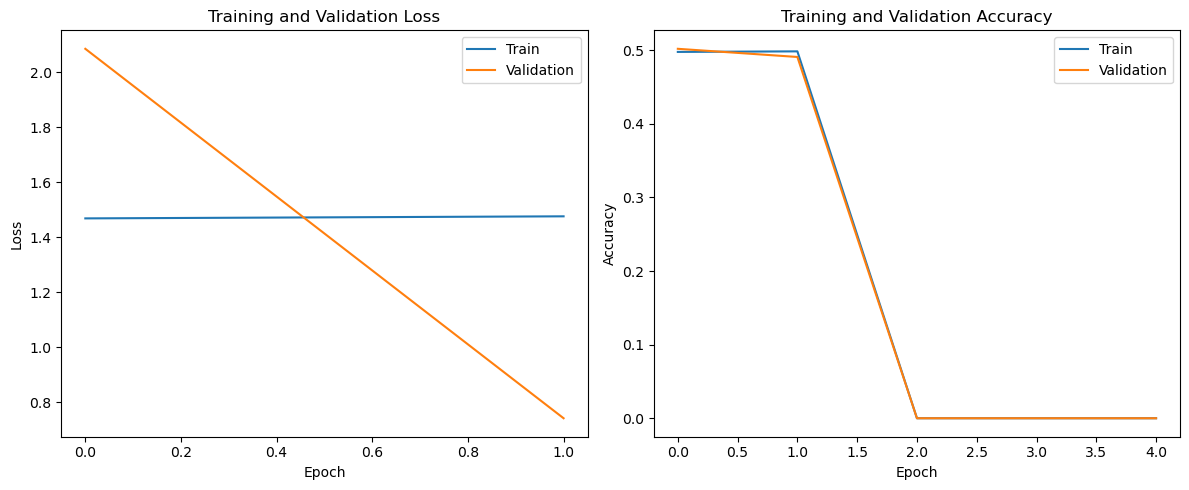

In [ ]:
# TO BE COMPLETED
# Run #1 lr = 0.1 , emb_size = 300 , hidden_size = 256, drop_rate = 0.5
vocab_size = len(stoi) + 1
model = SentimentRNN(vocab_size, 300, 256, 1, 2, 0.5)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_rnn_network(model, train_loader, valid_loader, num_epochs=5, learning_rate=0.1, device=device)

Epoch 1/5; Train Loss: 0.4902; Valid Loss: 0.3888; Train Acc: 0.8535; Valid Acc: 0.8244
Epoch 2/5; Train Loss: 0.3486; Valid Loss: 0.3679; Train Acc: 0.8797; Valid Acc: 0.8399
Epoch 3/5; Train Loss: 0.3096; Valid Loss: 0.3550; Train Acc: 0.8964; Valid Acc: 0.8465
Epoch 4/5; Train Loss: 0.2764; Valid Loss: 0.3623; Train Acc: 0.9122; Valid Acc: 0.8461
Epoch 5/5; Train Loss: 0.2420; Valid Loss: 0.3742; Train Acc: 0.9323; Valid Acc: 0.8472


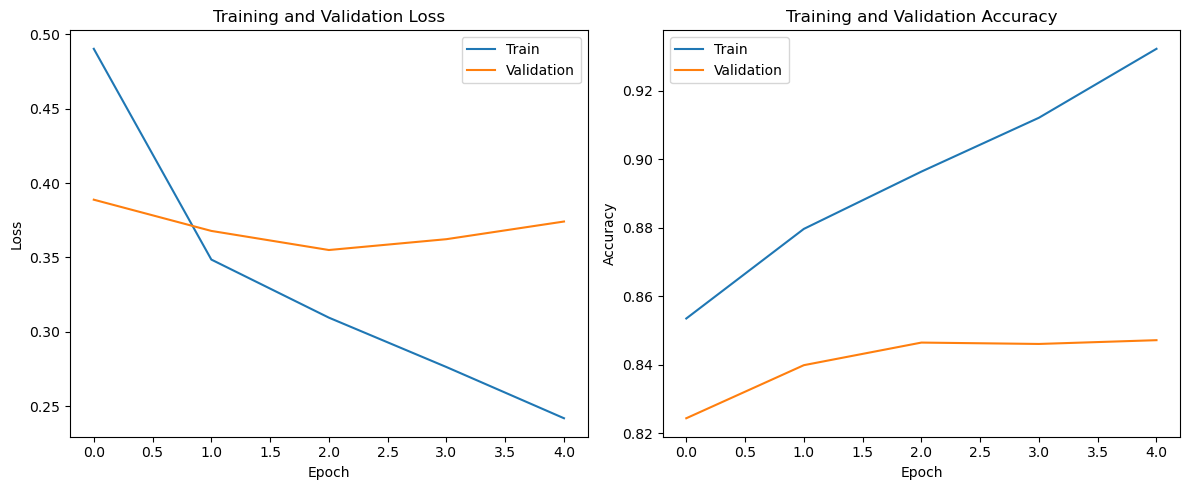

In [ ]:
# TO BE COMPLETED
# Run #2 lr = 0.0001 , emb_size = 500 , hidden_size = 256, drop_rate = 0.5
vocab_size = len(stoi) + 1
model = SentimentRNN(vocab_size, 500, 256, 1, 2, 0.5)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_rnn_network(model, train_loader, valid_loader, num_epochs=5, learning_rate=0.0001, device=device)

Epoch 1/5; Train Loss: 0.5757; Valid Loss: 0.4335; Train Acc: 0.8284; Valid Acc: 0.8034
Epoch 2/5; Train Loss: 0.3879; Valid Loss: 0.3824; Train Acc: 0.8628; Valid Acc: 0.8314
Epoch 3/5; Train Loss: 0.3448; Valid Loss: 0.3667; Train Acc: 0.8771; Valid Acc: 0.8387
Epoch 4/5; Train Loss: 0.3150; Valid Loss: 0.3590; Train Acc: 0.8903; Valid Acc: 0.8427
Epoch 5/5; Train Loss: 0.2921; Valid Loss: 0.3583; Train Acc: 0.9015; Valid Acc: 0.8445


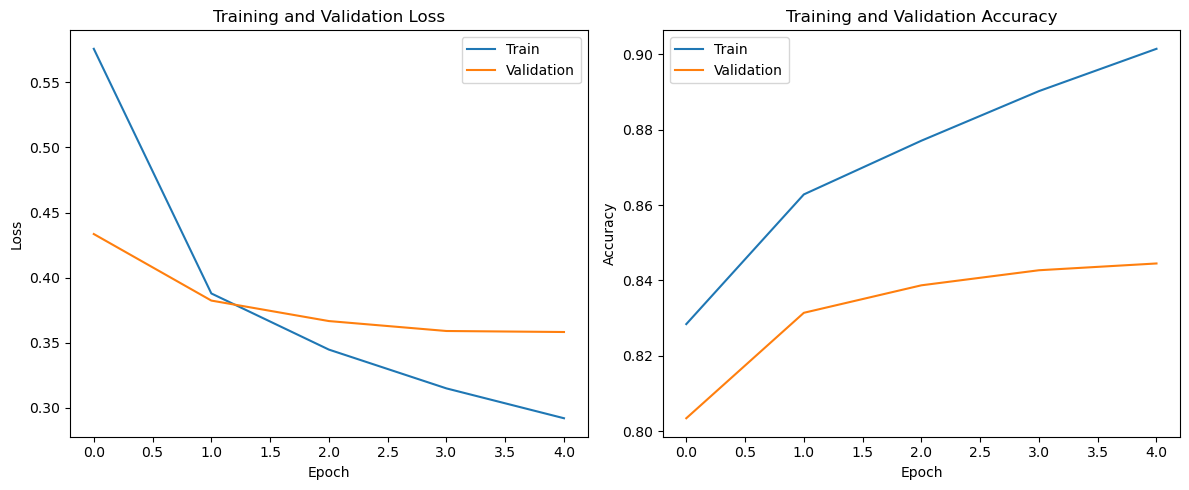

In [ ]:
# TO BE COMPLETED
# Run #3 lr = 0.0001 , emb_size = 300 , hidden_size = 128, drop_rate = 0.5
vocab_size = len(stoi) + 1
model = SentimentRNN(vocab_size, 300, 128, 1, 2, 0.5)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_rnn_network(model, train_loader, valid_loader, num_epochs=5, learning_rate=0.0001, device=device)

Epoch 1/5; Train Loss: 0.6008; Valid Loss: 0.4380; Train Acc: 0.8241; Valid Acc: 0.7944
Epoch 2/5; Train Loss: 0.3981; Valid Loss: 0.4018; Train Acc: 0.8530; Valid Acc: 0.8192
Epoch 3/5; Train Loss: 0.3551; Valid Loss: 0.3715; Train Acc: 0.8749; Valid Acc: 0.8357
Epoch 4/5; Train Loss: 0.3264; Valid Loss: 0.3633; Train Acc: 0.8849; Valid Acc: 0.8402
Epoch 5/5; Train Loss: 0.3042; Valid Loss: 0.3638; Train Acc: 0.8969; Valid Acc: 0.8419


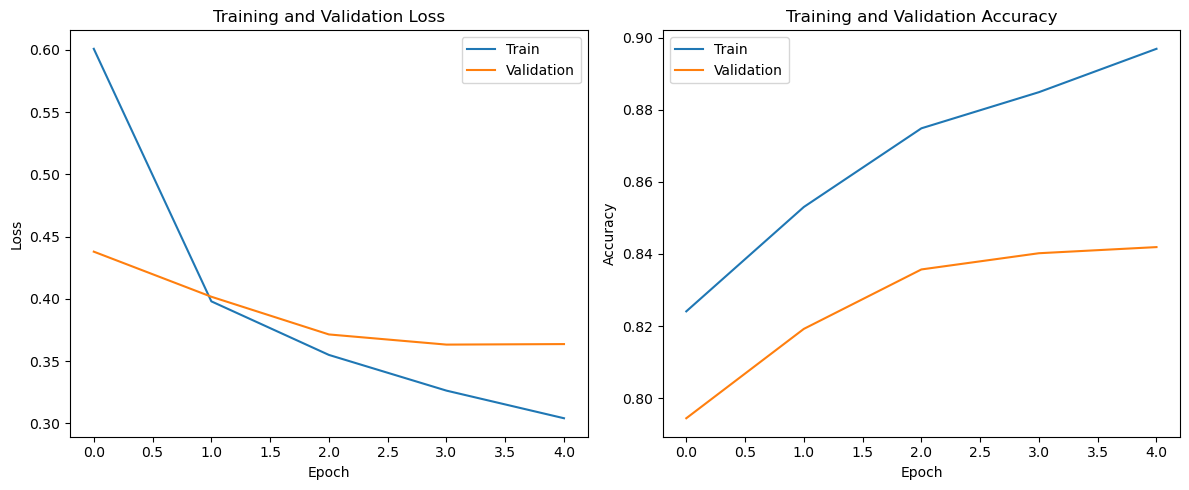

In [ ]:
# TO BE COMPLETED
# Run #4 lr = 0.0001 , emb_size = 300 , hidden_size = 256, drop_rate = 0.8
vocab_size = len(stoi) + 1
model = SentimentRNN(vocab_size, 300, 256, 1, 2, 0.8)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_rnn_network(model, train_loader, valid_loader, num_epochs=5, learning_rate=0.0001, device=device)

Epoch 1/10; Train Loss: 0.4921; Valid Loss: 0.3940; Train Acc: 0.8509; Valid Acc: 0.8222
Epoch 2/10; Train Loss: 0.3495; Valid Loss: 0.3641; Train Acc: 0.8797; Valid Acc: 0.8405
Epoch 3/10; Train Loss: 0.3087; Valid Loss: 0.3667; Train Acc: 0.8887; Valid Acc: 0.8362
Epoch 4/10; Train Loss: 0.2779; Valid Loss: 0.3554; Train Acc: 0.9059; Valid Acc: 0.8415
Epoch 5/10; Train Loss: 0.2422; Valid Loss: 0.3690; Train Acc: 0.9311; Valid Acc: 0.8467
Epoch 6/10; Train Loss: 0.2066; Valid Loss: 0.4030; Train Acc: 0.9450; Valid Acc: 0.8432
Epoch 7/10; Train Loss: 0.1665; Valid Loss: 0.4352; Train Acc: 0.9586; Valid Acc: 0.8422
Epoch 8/10; Train Loss: 0.1292; Valid Loss: 0.4901; Train Acc: 0.9670; Valid Acc: 0.8359
Epoch 9/10; Train Loss: 0.1030; Valid Loss: 0.5242; Train Acc: 0.9824; Valid Acc: 0.8387
Epoch 10/10; Train Loss: 0.0745; Valid Loss: 0.5595; Train Acc: 0.9792; Valid Acc: 0.8355


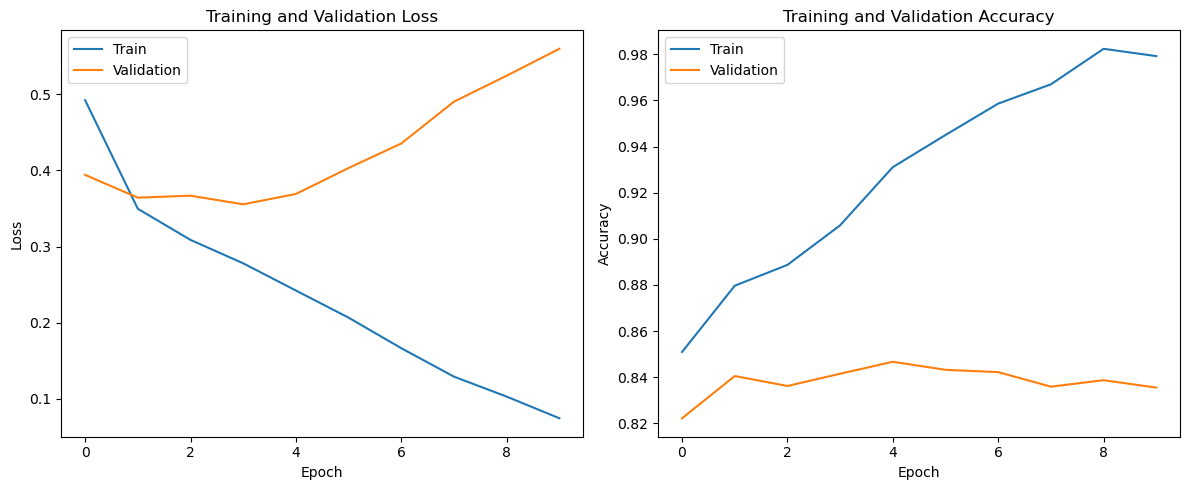

In [ ]:
# TO BE COMPLETED
# Run #5 lr = 0.0001 , emb_size = 500 , hidden_size = 256, drop_rate = 0.5 ##More epochs##
vocab_size = len(stoi) + 1
model = SentimentRNN(vocab_size, 500, 256, 1, 2, 0.5)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_rnn_network(model, train_loader, valid_loader, num_epochs=10, learning_rate=0.0001, device=device)

In [ ]:
'''
PROVIDE YOUR ANSWER BELOW

I choose the following hyperparameter as my tunning parameter:
learning rate, emb_size , hidden_size and drop_rate

After tunning process, the validation accuracy is not affected very much. The highest validation accuracy
is 85.%

'''

'\nPROVIDE YOUR ANSWER BELOW\n\nI choose the following hyperparameter as my tunning parameter:\nlearning rate, emb_size , hidden_size and drop_rate\n\nAfter tunning process, the validation accuracy is not affected very much. The highest validation accuracy\nis 85.%\n\n'

## Part 4. Evaluation [10 pt]

**Important**. At this point in the assignment your test data should not have been evaluated by any of your models. The test data should be evaluated only after you have finished all the previous parts of the assignment. Once you evaluate your models on the test data you cannot change your models or else you may make hyperparameter adjustments that could lead to overfitting to the test data.

### Part (i) [3pt RESULT]

Report the final test accuracy of your model. Comment on how the result compares with accuracy obtained on the training and validation data. Are the results what you expected? Explain.

In [ ]:
# TO BE COMPLETED
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
accuracy = get_accuracy(model, test_loader,device = device)
print(f"Final Test Accuracy: {accuracy * 100:.2f}%")

Final Test Accuracy: 84.36%


In [ ]:
'''
PROVIDE YOUR ANSWER BELOW

Train acc: 93.23%
Valid acc: 84.72%
Test acc: 84.36%

This is a promising result but train accuacry seems a bit high. There are still a slight overfit exisit in my best model.


'''


### Part (ii) [3pt DISCUSSION]

Look over the misclassified samples in the test data and see if you can find any patterns on where the model has difficulty with identifying the review sentiment. Provide up to 5 examples of positive and negative reviews each to support your findings.

In [ ]:
# TO BE COMPLETED

# Convert tensor to text msg
def tensor_to_text(tensor, stoi_reverse):
    word_indices = tensor.tolist()

    # Check if value is in the stoi_reverse keys
    words = [stoi_reverse.get(value, '') for value in word_indices]

    # Filter out empty space
    words = [word for word in words if word]

    original_text = ' '.join(words)

    return original_text

# Count and local misclassified data and tensor
def analyze_misclassified(model, test_loader, device, stoi_reverse):
    model.eval()

    misclassified_positive = []
    misclassified_negative = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs, _ = model(inputs, None)
            predictions = torch.round(torch.sigmoid(outputs)).squeeze()

            # Identify misclassified samples
            misclassified_idx = (predictions != labels)

            # Extract text and true labels of misclassified samples
            misclassified_texts = [tensor_to_text(text, stoi_reverse) for text, label in zip(inputs[misclassified_idx], labels[misclassified_idx])]
            misclassified_labels = [label.item() for label in labels[misclassified_idx]]
            predicted_labels = [prediction.item() for prediction in predictions[misclassified_idx]]

            # Print statements for debugging
            for text, true_label, predicted_label in zip(misclassified_texts, misclassified_labels, predicted_labels):

                # Group misclassified samples by true sentiment
                misclassified_sample = {'text': text, 'true_label': true_label, 'predicted_label': predicted_label}

                if true_label == 1 and predicted_label == 0:
                    misclassified_positive.append(misclassified_sample)
                elif true_label == 0 and predicted_label == 1:
                    misclassified_negative.append(misclassified_sample)

    return misclassified_positive, misclassified_negative

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Get the reverse mapping of stoi for converting indices back to words
stoi_reverse = {i + 1: ch for i, ch in enumerate(stoi)}

misclassified_positive, misclassified_negative = analyze_misclassified(model, test_loader, device, stoi_reverse)

# Print the total number of misclassified samples
print(f"Total Misclassified Positive Reviews: {len(misclassified_positive)}")
print(f"Total Misclassified Negative Reviews: {len(misclassified_negative)}")

# Print 5 examples of misclassified positive reviews
print("\nMisclassified Positive Reviews:")
for i, sample in enumerate(misclassified_positive[:min(5, len(misclassified_positive))]):
    print(f"Example {i + 1}")
    print(f"True Label: {sample['true_label']}, Predicted Label: {sample['predicted_label']}")
    print(f"Text: {sample['text']}\n")  # Add newline after printing text

# Print 5 examples of misclassified negative reviews
print("\nMisclassified Negative Reviews:")
for i, sample in enumerate(misclassified_negative[:min(5, len(misclassified_negative))]):
    print(f"Example {i + 1}")
    print(f"True Label: {sample['true_label']}, Predicted Label: {sample['predicted_label']}")
    print(f"Text: {sample['text']}\n")  # Add newline after printing text

Total Misclassified Positive Reviews: 879
Total Misclassified Negative Reviews: 685

Misclassified Positive Reviews:
Example 1
True Label: 1.0, Predicted Label: 0.0
Text: movie may great watched last night feel give opinion read book first book much better movie disappointed film watch human dont read book hand book good much love could still enjoy seeing movie make average reading book every days read human gets one top ten ever written

Example 2
True Label: 1.0, Predicted Label: 0.0
Text: without doubt one horror films ever really cannot believe didnt much released especially main time usual style suspense plot movie black comedy great plot never good movie difficult enjoy film br plot girl working set horror film made series events finds moviebr br one best things film lack seems every horror film ever made main character cannot make something movie br director seems well even opening scene well fairly movie br acting times whole film hold together couple excellent scenes put right

In [ ]:
'''
PROVIDE YOUR ANSWER BELOW

By analyzing the misclassified samples, it appears that most of those samples is not interperable because
we create our own embedding space (stoi) with only 1000 words. This is too small for coverting most of
the reviews to integers. A more various embedding like gloves (more than 10k words) should be implemented
if we want to improve this model.

'''


### Part (iii) [2pt RESULT]

What is your model's prediction of the **probability** that
the review message provided below is a positive review?

Hint: You will need to apply the same processing on the review as was done on the the train, val, and test data sets.

In [ ]:
review = """ Man.... I wish I loved this movie more than I did. Don't get me wrong,
it's a solid action movie with jaw-dropping stunts (some of the best in the series),
but as a Mission: Impossible movie, it felt like a small step backward for the franchise.
Fallout had mind-blowing action sequences and stunt work, along with developing Ethan's
relationship with Ilsa, providing closure with Julia, showing the lengths Ethan would
go to protect those closest to him, and battling an imposing villain. Dead Reckoning:
Part One stretches the movie across two films only to seemingly showcase action
spectacle after action spectacle while sacrificing character development.
Characters I have grown to love over a decade of films felt sidelined, ignored,
or wasted. Hayley Atwell's new character chewed up most of the screen time, and
while she was fantastic, I wanted to see more of the original team. The new villain
had an inconsistent ability that confused more than intimidated. There were some
important emotional moments that I just didn't feel the weight of when I definitely
should have. Part Two might tie everything together and make me enjoy Part One
more in retrospect, but unfortunately, I left wanting more from this one. """



In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Preprocess the review
review_tokenize = [stoi[word] for word in preprocess_sentence(review) if word in stoi]
review_padded = padding_([review_tokenize], 500)
review_tensor = torch.tensor(review_padded, dtype=torch.long).to(device)

# Initialize the hidden state
hidden = (torch.zeros(2, 1, 256).to(device), torch.zeros(2, 1, 256).to(device))

model.eval()
with torch.no_grad():
    # Make the prediction
    output, _ = model(review_tensor, hidden)
    prediction = torch.sigmoid(output).item()

print(f"Probability of a positive review: {prediction * 100:.2f}%")

Probability of a positive review: 88.90%


### Part (iv) [2pt DISCUSSION]

Do you think that detecting positive and negative reviews is an easy or difficult task?

Since machine learning models are expensive to train and deploy, it is very
important to compare our models against baseline models: a simple
model that is easy to build and inexpensive to run that we can compare our
recurrent neural network model against.

Explain how you might build a simple baseline model. This baseline model
can be a simple neural network (with very few weights), a hand-written algorithm,
or any other strategy that is easy to build and test.

**Do not actually build a baseline model. Instead, provide instructions on
how to build it.**

In [ ]:
'''
PROVIDE YOUR ANSWER BELOW

We can use the bag of words approach to build a baseline model

1. Data Processing:
    Represent each review as a bag of words, ignoring grammar and word order.
    Apply tokenization to break down reviews into individual words.

2.Feature Extraction:
    Create a vocabulary (soti): Collect a list of unique words across all reviews.
    For each review, create a feature vector indicating the presence or absence of each
    word in the vocabulary.

3.Model Architecture:
    Use a generally simple linear model such as Logistic Regression.
    Assign weights to each word in soti to predict the sentiment by on the sumation of weight.

4.Training Process:
    Split the dataset into training, validation  and test sets.
    Train the Logistic Regression model on the training set using the feature vectors and
    corresponding labels. Then validate the model with validation sets.

5.Evaluation:
    Evaluate the model on the test set using metrics such as confusion matrix and F1 score.
'''

# PART B - Transfer Learning

For many natural language processing tasks, it is generally not a good idea to train a very large deep neural network model from scratch due to enormous compute requirements and lack of sufficient amounts of training data. Instead, you should always try to take advantage of an existing model that performs similar tasks as the one you need to solve.

In this part of the assignment we will be using pretrained models to improve the performance on identifying positive and negative reviews. There are several pretrained models that are available to us, here we will use a pretrained BERT model that comes with the hugging face transformer library.

Provided below is sample code to get you started. For more details please visit the hugging face tutorial on using pretrained models using PyTorch: https://huggingface.co/docs/transformers/training

#### Sample Code

In [ ]:
# install relevant libraries
!pip install transformers

In [ ]:
# load relevant libraries
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup

PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)


In [ ]:
sample_txt = 'I want to learn how to do sentiment analysis using BERT and tokenizer.'

encoding = tokenizer.encode_plus(
  sample_txt,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  padding= 'max_length',
  max_length=32,
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
  truncation = True
)

In [ ]:
encoding['input_ids']

tensor([[  101,   146,  1328,  1106,  3858,  1293,  1106,  1202, 17024,  3622,
          1606,   139,  9637,  1942,  1105, 22559, 17260,   119,   102,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0]])

In [ ]:
encoding['attention_mask']

tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])

In [ ]:
hidden_states = bert_model(input_ids=encoding['input_ids'],
                           attention_mask=encoding['attention_mask'])[0]
pooled_output = bert_model(input_ids=encoding['input_ids'],
                           attention_mask=encoding['attention_mask'])[1]

In [ ]:
hidden_size = bert_model.config.hidden_size

print(hidden_size)
print(hidden_states.shape)
print(pooled_output.shape)


768
torch.Size([1, 32, 768])
torch.Size([1, 768])


In the sample code provided we loaded a short text sequence, tokenized it using the same tokenization that was used in the pretrained BERT model, and fed the tokenized input into the BERT model to obtain the embeddings.

The model output consists of two forms of embeddings:
- **hidden_states** are the final layer of outputs that has a shape sequence_length x embeddings, much like the hidden states of a recurrent neural network
- **pooled_output** is the result of applying max pooling on the hidden states to effectively collapse the sequence dimenension and ensure the same output size for any given sequence before feeding into the classification stage

Note that you can preprocess all of the data prior to training a classifier stage for sentiment analysis to help speed up the training process. This is no different from the process we applied in an earlier assignment using AlexNet and image data.

## Part 1. Data Loading [5 pt]

We will be using the same "IMDB Movie Review Dataset" that we used earlier. Reload the data and complete Part B of the assignment. You should be able to complete part B independently from Part A.

### Part (i) [1pt EXPLORATORY]

Provided below is a DataLoader for your training and test datasets so you can iterate over batches of data. Run the DataLoader to create your training, validation, and test data.

In [ ]:
from torch.utils.data import Dataset, DataLoader

class MovieReviewDataset(Dataset):

  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.reviews)

  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
      truncation = True
    )

    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [ ]:
# prepare data loaders
MAX_LEN = 400
BATCH_SIZE = 16

# load dataset
df = pd.read_csv(filepath_or_buffer='/content/drive/MyDrive/Colab Notebooks/MIE1517/IMDB Dataset.csv')
# Encode all sentiment labels to either 1 or 0
df['sentiment'] = df['sentiment'].map({'positive': 1, 'negative': 0})

# Split the data into train, valid, and test sets
df_train, temp = train_test_split(df, test_size=0.4, random_state=0)
df_valid, df_test = train_test_split(temp, test_size=0.5, random_state=0)

# Print shape of all data
print(f"Train set size: {len(df_train)}")
print(f"Validation set size: {len(df_valid)}")
print(f"Test set size: {len(df_test)}")

#training data
train_data = MovieReviewDataset(reviews=df_train['review'].to_numpy(),
                                targets=df_train['sentiment'].to_numpy(),
                                tokenizer=tokenizer,
                                max_len=MAX_LEN)

train_data_loader = DataLoader(train_data, batch_size=BATCH_SIZE, num_workers=4) #modify num_works as needed

#validation data

# TO BE COMPLETED
valid_data = MovieReviewDataset(reviews=df_valid['review'].to_numpy(),
                                targets=df_valid['sentiment'].to_numpy(),
                                tokenizer=tokenizer,
                                max_len=MAX_LEN)

valid_data_loader = DataLoader(valid_data, batch_size=BATCH_SIZE, num_workers=4)

#test data

# TO BE COMPLETED
test_data = MovieReviewDataset(reviews=df_test['review'].to_numpy(),
                               targets=df_test['sentiment'].to_numpy(),
                               tokenizer=tokenizer,
                               max_len=MAX_LEN)

test_data_loader = DataLoader(test_data, batch_size=BATCH_SIZE, num_workers=4)




Train set size: 30000
Validation set size: 10000
Test set size: 10000


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
# Load saved embeddings and labels

# load dataset
df = pd.read_csv(filepath_or_buffer='/content/drive/MyDrive/Colab Notebooks/MIE1517/IMDB Dataset.csv')
# Encode all sentiment labels to either 1 or 0
df['sentiment'] = df['sentiment'].map({'positive': 1, 'negative': 0})
# Split the data into train, valid, and test sets
df_train, temp = train_test_split(df, test_size=0.4, random_state=0)
df_valid, df_test = train_test_split(temp, test_size=0.5, random_state=0)

file_path_train = '/content/drive/MyDrive/Colab Notebooks/MIE1517/bert_train_embeddings.npy'
file_path_valid = '/content/drive/MyDrive/Colab Notebooks/MIE1517/bert_val_embeddings.npy'
file_path_test = '/content/drive/MyDrive/Colab Notebooks/MIE1517/bert_test_embeddings.npy'

# Load embeddings and labels
try_train_embeddings = np.load(file_path_train)
try_train_labels = df_train['sentiment'].values.squeeze()

try_valid_embeddings = np.load(file_path_valid)
try_valid_labels = df_valid['sentiment'].values.squeeze()

try_test_embeddings = np.load(file_path_test)
try_test_labels = df_test['sentiment'].values.squeeze()

try_train_embeddings_tensor = torch.tensor(try_train_embeddings, dtype=torch.float32)
try_train_labels_tensor = torch.tensor(try_train_labels, dtype=torch.long)
try_valid_embeddings_tensor = torch.tensor(try_valid_embeddings, dtype=torch.float32)
try_valid_labels_tensor = torch.tensor(try_valid_labels, dtype=torch.long)
try_test_embeddings_tensor = torch.tensor(try_test_embeddings, dtype=torch.float32)
try_test_labels_tensor = torch.tensor(try_test_labels, dtype=torch.long)

batch_size = 64 #Batch size

try_train_dataset = TensorDataset(try_train_embeddings_tensor, try_train_labels_tensor)
try_train_loader = DataLoader(try_train_dataset, batch_size=batch_size, shuffle=True)
try_valid_dataset = TensorDataset(try_valid_embeddings_tensor, try_valid_labels_tensor)
try_valid_loader = DataLoader(try_valid_dataset, batch_size=batch_size, shuffle=False)
try_test_dataset = TensorDataset(try_test_embeddings_tensor, try_test_labels_tensor)
try_test_loader = DataLoader(try_test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
bert_model = BertModel.from_pretrained('bert-base-cased')
bert_model.eval()

# Function to save bert embeddings
def save_embeddings(model, dataloader, embeded):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()
    embeddings = []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            pooled_output = outputs.pooler_output
            embeddings.append(pooled_output.cpu().numpy())

    embeddings = np.concatenate(embeddings, axis=0)
    np.save(embeded, embeddings)

# Save embeddings without allowing pickling
save_embeddings(bert_model, train_data_loader, 'bert_train_embeddings1.npy')
save_embeddings(bert_model, valid_data_loader, 'bert_val_embeddings1.npy')
save_embeddings(bert_model, test_data_loader, 'bert_test_embeddings1.npy')

### Part (ii) [1pt EXPLORATORY]

Use the **train_data_loader** to load one sample. What are the different attributes provided with the sample and how are they used?

In [ ]:
# TO BE COMPLETED

# Pick one batch from dataloader
for batch in train_data_loader:
    sample = batch
    break  # Break after the first batch to get only one sample

# Print out the attributes of the sample
print("Sample keys:", sample.keys())

# Access individual attributes
reviews = sample['input_ids']
targets = sample['targets']
attention_mask = sample['attention_mask']

# Print the shapes of the tensors
print("Reviews shape:", reviews.shape)
print("Targets shape:", targets.shape)
print("Attention Mask shape:", attention_mask.shape)


NameError: ignored

In [ ]:
'''
PROVIDE YOUR ANSWER BELOW
There are three attributes asscioate with the sample which are input_ids , targets and attention_mask.
Input_ids is used to tokenized input sequence and convert them into numerical representations.
Attention_mask is a tensor mask padding tokens to indicate the position of the actual value.
Targets is the sentiment labels.
'''

### Part (iii) [1pt EXPLORATORY]

Determine the range of values for the tokens in the training data. How are the tokens obtained?

Hint: You can apply your intuition here, or do some additional research to find how the "bert-base-cased" tokenization is done.

In [ ]:
# TO BE COMPLETED

# Get the vocabulary
vocab = tokenizer.get_vocab()

# Find the minimum and maximum token IDs
min_token_id = min(vocab.values())
max_token_id = max(vocab.values())

print("Minimum Token ID:", min_token_id)
print("Maximum Token ID:", max_token_id)


Minimum Token ID: 0
Maximum Token ID: 28995


In [ ]:
'''
PROVIDE YOUR ANSWER BELOW
In the process of "bert-base-cased" tokenization. Word is break into small pieces for example, enjoying
will be break into enjoy and ..ing. Each sub-word picece will have an unique integer to be its id.
In addition, there are different id sets for tokens like CLS , SEP and MASK.
'''

### Part (iv) [1pt EXPLORATORY]

Generate histograms of all the token values in the training data. Repeat for the validation and test data. What are the top 5 occuring tokens in the training_dataset? What do these tokens represent?

In [ ]:
# TO BE COMPLETED

# Function to generate histograms and find top tokens
def plot_and_get_top_tokens(token_ids, title, tokenizer, n=5):
    # Generate histogram
    plt.figure(figsize=(12, 6))
    sns.histplot(token_ids, bins=30, kde=False, color='blue')
    plt.title(title)
    plt.xlabel('Token ID')
    plt.ylabel('Frequency')
    plt.show()

    # Top tokens
    token_counts = torch.bincount(torch.tensor(token_ids))
    sorted_indices = torch.argsort(token_counts, descending=True)
    top_tokens = [(idx.item(), count.item()) for idx, count in zip(sorted_indices[:n], token_counts[sorted_indices][:n])]

    # Print token meanings
    print(f"\nTop {n} occurring tokens and their meanings:")
    for token_id, count in top_tokens:
        token = tokenizer.decode(token_id)
        print(f"Token ID: {token_id}, Count: {count}, Token: {token}")

    return top_tokens


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

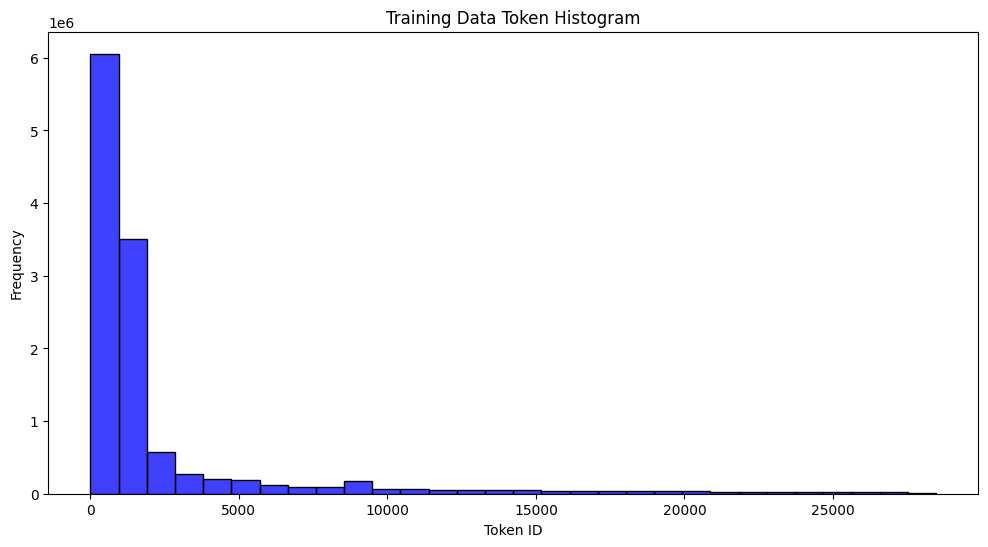


Top 5 occurring tokens and their meanings:
Token ID: 0, Count: 4276412, Token: [ P A D ]
Token ID: 119, Count: 319265, Token: .
Token ID: 1103, Count: 276886, Token: t h e
Token ID: 117, Count: 261168, Token: ,
Token ID: 170, Count: 154248, Token: a


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.war

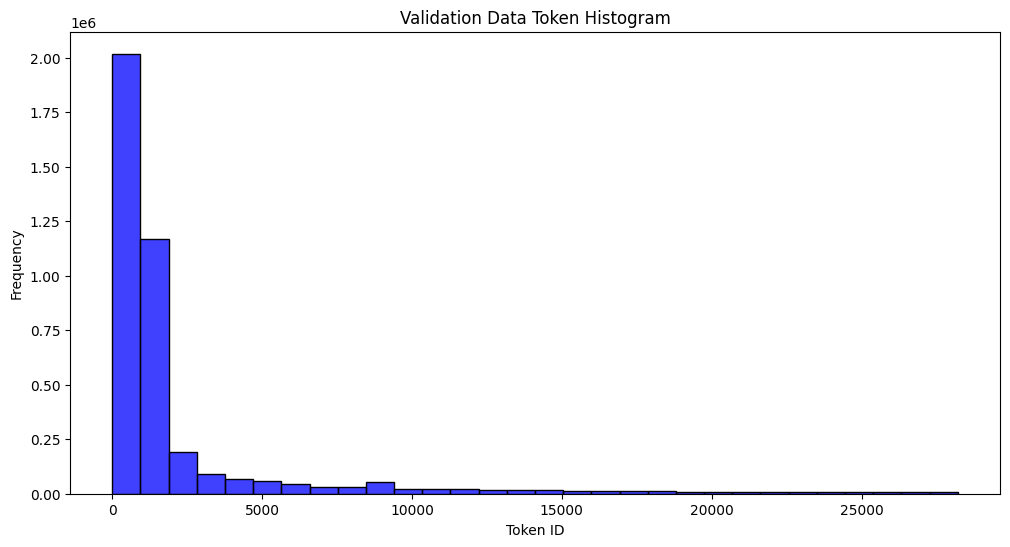


Top 5 occurring tokens and their meanings:
Token ID: 0, Count: 1424150, Token: [ P A D ]
Token ID: 119, Count: 105763, Token: .
Token ID: 1103, Count: 92192, Token: t h e
Token ID: 117, Count: 86496, Token: ,
Token ID: 170, Count: 51185, Token: a


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.war

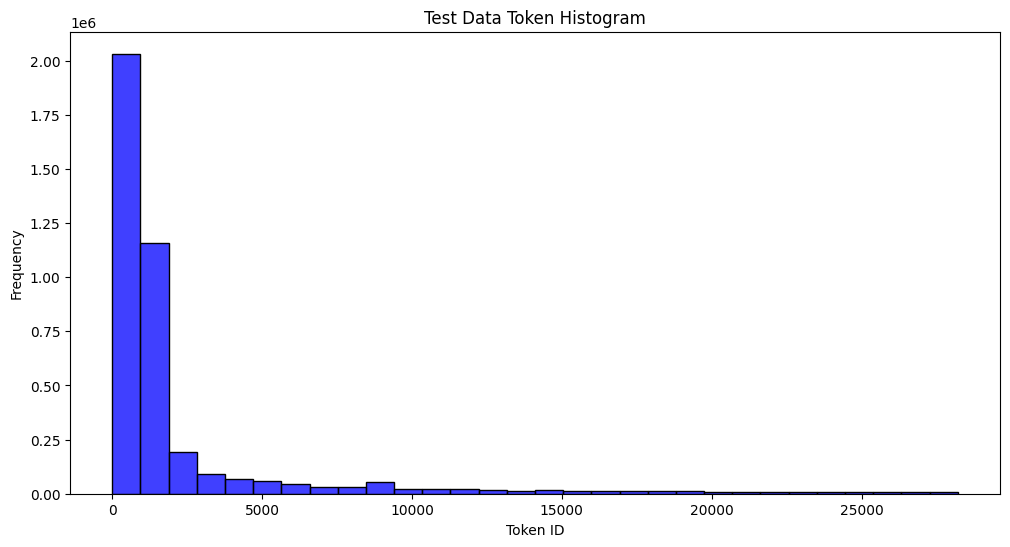


Top 5 occurring tokens and their meanings:
Token ID: 0, Count: 1441700, Token: [ P A D ]
Token ID: 119, Count: 105850, Token: .
Token ID: 1103, Count: 91709, Token: t h e
Token ID: 117, Count: 85559, Token: ,
Token ID: 170, Count: 50866, Token: a


[(0, 1441700), (119, 105850), (1103, 91709), (117, 85559), (170, 50866)]

In [ ]:
# Training data
train_token_ids = []
for batch in train_data_loader:
    train_token_ids.extend(batch['input_ids'].view(-1).numpy())

plot_and_get_top_tokens(train_token_ids, title='Training Data Token Histogram', tokenizer=tokenizer)

# Validation data
valid_token_ids = []
for batch in valid_data_loader:
    valid_token_ids.extend(batch['input_ids'].view(-1).numpy())

plot_and_get_top_tokens(valid_token_ids, title='Validation Data Token Histogram', tokenizer=tokenizer)

# Test data
test_token_ids = []
for batch in test_data_loader:
    test_token_ids.extend(batch['input_ids'].view(-1).numpy())

plot_and_get_top_tokens(test_token_ids, title='Test Data Token Histogram', tokenizer=tokenizer)

In [ ]:
'''
PROVIDE YOUR ANSWER BELOW

Top 5 occurring tokens in training data and their meanings:
Token ID: 0, Count: 4276412, Token: [ P A D]
Token ID: 119, Count: 319265, Token: .
Token ID: 1103, Count: 276886, Token: t h e
Token ID: 117, Count: 261168, Token: ,
Token ID: 170, Count: 154248, Token: a

'''

### Part (v) [1pt EXPLORATORY]

Select a single sample from your training DataLoader and feed it through the **bert_model** to obtain the hidden_states and pooled_output. Briefly describe what each tensor dimension represents and what affects the size of each dimension.

In [ ]:
# TO BE COMPLETED
for batch in train_data_loader:
    input_ids = batch['input_ids'][0]  # Take the input_ids for the first sample in the batch
    attention_mask = batch['attention_mask'][0]  # Take the attention_mask for the first sample in the batch
    break

# Assuming your model is loaded and tokenizer is defined as mentioned in the question
encoding = {'input_ids': input_ids.unsqueeze(0), 'attention_mask': attention_mask.unsqueeze(0)}

# Feed the input through the bert_model
hidden_states, pooled_output = bert_model(input_ids=encoding['input_ids'],
                                           attention_mask=encoding['attention_mask'])

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

In [ ]:
'''
PROVIDE YOUR ANSWER BELOW

Hidden States (hidden_states):

Dimensions: [batch_size, sequence_length, hidden_size]
This tensor contains the hidden states for each token in the input sequence.
batch_size: Number of samples in the batch.
sequence_length: Number of tokens in the input sequence (padded to the maximum length).
hidden_size: Dimensionality of the hidden states. For 'bert-base-cased', it is 768.
The size of hidden_states is affected by the batch size and the length of the input sequence.
Pooled Output (pooled_output):

Dimensions: [batch_size, hidden_size]
This tensor is a representation of the entire input sequence after pooling.
It is commonly used as the input representation for downstream classification tasks.
batch_size: Number of samples in the batch.
hidden_size: Dimensionality of the hidden states. For 'bert-base-cased', it is 768.
The size of pooled_output is affected by the batch size and the length of the input sequence.
The size of each dimension is influenced by the architecture of the BERT model (e.g., 'bert-base-cased' has 768 hidden units), the batch size, and the length of the input sequence. Make sure that your input sequence length does not exceed the model's maximum sequence length, which is typically 512 for BERT.




'''

## Part 2. Model Architecture [2 pt]

### Part (i) [1pt MODEL]

Prepare a review classifier model that builds on the pooled output from the Bert model to identify positive and negative reviews.

In [ ]:
class SentimentClassifierPooled(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifierPooled, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

    # TO BE COMPLETED

    self.dropout = nn.Dropout(p=0.3)
    self.linear = nn.Linear(self.bert.config.hidden_size, n_classes)
    self.sigmoid = nn.Sigmoid()

  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
      # TO BE COMPLETED

        # Apply dropout
    pooled_output = self.dropout(pooled_output)

        # Linear layer for classification
    logits = self.linear(pooled_output)

        # Sigmoid activation for binary classification
    probabilities = self.sigmoid(logits)

    return probabilities




### Part (ii) [1pt MODEL]

Construct the architecture for a review classifier model that uses the last hidden output from the Bert model to identify positive and negative reviews.

In [ ]:
class SentimentClassifier(nn.Module):
    def __init__(self, embedding_dim=768, drop_out=0.3):
        super(SentimentClassifier, self).__init__()
        self.drop = nn.Dropout(drop_out)
        self.fc1 = nn.Linear(embedding_dim, embedding_dim)
        self.fc2 = nn.Linear(embedding_dim, int(embedding_dim/2))
        self.fc3 = nn.Linear(int(embedding_dim/2), 1)  # Change the output size to 1
        self.relu = nn.ReLU()

    def forward(self, embeddings):
        x = self.drop(embeddings)
        x = self.relu(self.fc1(x))
        x = self.drop(x)
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
import torch.nn as nn

class SentimentClassifierRNN(nn.Module):
    def __init__(self, embedding_dim=768, hidden_dim=256, num_layers=1, drop_out=0.3):
        super(SentimentClassifierRNN, self).__init__()
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        # LSTM layer
        self.rnn = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers, batch_first=True, dropout=drop_out, bidirectional=True)

        # Fully connected layers
        self.fc1 = nn.Linear(hidden_dim * 2, hidden_dim)  # Multiply by 2 for bidirectional
        self.fc2 = nn.Linear(hidden_dim, 1)  # Change the output size to 1
        self.relu = nn.ReLU()

        # Dropout layer
        self.drop = nn.Dropout(drop_out)

    def forward(self, embeddings):
        # LSTM input shape: (batch_size, sequence_length, embedding_dim)
        lstm_out, _ = self.rnn(embeddings)

        # Extract the output from the last time step
        last_output = lstm_out[:, -1, :]

        # If the last_output tensor has more than 2 dimensions, squeeze it
        last_output = last_output.squeeze()

        x = self.drop(last_output)
        x = self.relu(self.fc1(x))
        x = self.drop(x)
        x = self.fc2(x)

        return x


In [ ]:
class SentimentClassifierLast(nn.Module):
    def __init__(self, n_classes, dropout_rate=0.3, hidden_layer_size=768):
        super(SentimentClassifierLast, self).__init__()
        self.dropout = nn.Dropout(p=dropout_rate)
        self.linear = nn.Linear(hidden_layer_size, hidden_layer_size)
        self.output_linear = nn.Linear(hidden_layer_size, n_classes)
        self.sigmoid = nn.Sigmoid()

        # Load pre-saved BERT embeddings
        self.load_bert_embeddings()

    def load_bert_embeddings(self):
        # Load the pre-saved BERT embeddings
        self.bert_embeddings = np.load('bert_train_embeddings.npy')
        self.register_buffer('bert_embeddings', torch.tensor(self.bert_embeddings, dtype=torch.float32))

    def forward(self, input_ids, attention_mask):
        # Use the loaded BERT embeddings
        cls_token = self.bert_embeddings

        # Apply dropout
        cls_token = self.dropout(cls_token)

        # Linear layer with ReLU activation for an additional hidden layer
        hidden_layer = self.linear(cls_token)

        # Linear layer for classification
        logits = self.output_linear(hidden_layer)

        # Sigmoid activation for binary classification
        probabilities = self.sigmoid(logits)

        return probabilities



## Part 3. Training [3 pt]

### Part (i) [1pt MODEL]

Complete the `get_accuracy` function, which will compute the
accuracy (rate) of your model across a dataset (e.g. validation set).

In [ ]:
def get_accuracy(model, data_loader, device):
    """ Compute the accuracy of the `model` across a dataset `data_loader`

    Args:
        model (torch.nn.Module): The PyTorch model.
        data_loader (torch.utils.data.DataLoader): DataLoader containing input and label pairs.
        device (str): Device to which the model and data should be moved.

    Returns:
        float: Accuracy of the model on the given dataset in percentage.
    """
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for embeddings, targets in data_loader:
            embeddings, targets = embeddings.to(device), targets.to(device)

            # Assuming your model returns a single output for binary classification
            outputs = model(embeddings)

            # Convert probabilities to binary predictions (0 or 1) using a threshold
            predictions = torch.round(torch.sigmoid(outputs))

            total += targets.size(0)
            correct += (predictions.squeeze() == targets).sum().item()

    accuracy = correct / total * 100
    return accuracy


### Part (ii) [1pt MODEL]

Write a function **train_model** to train your model. Plot the training curve of your final model.
Your training curve should have the training/validation loss and
accuracy plotted periodically.

In [ ]:
def train_model(model, train_loader, valid_loader, num_epochs=3, learning_rate=1e-5, device="cpu"):
    model = model.to(device)
    criterion = nn.BCEWithLogitsLoss()  # Binary Cross Entropy with Logits
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    train_losses, valid_losses, train_acc, valid_acc = [], [], [], []
    epochs = []

    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0.0

        for embeddings, targets in train_loader:
            embeddings, targets = embeddings.to(device), targets.to(device)

            # Ensure that the input is 3D
            if embeddings.dim() == 2:
                embeddings = embeddings.unsqueeze(1)

            optimizer.zero_grad()
            outputs = model(embeddings)

            # Modify the target tensor
            targets = targets.unsqueeze(1).float()

            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Accuracy calculation for training set
        train_accuracy = get_accuracy(model, train_loader, device)
        train_acc.append(train_accuracy)

        # Validation loss and accuracy calculation
        model.eval()
        total_valid_loss = 0.0

        with torch.no_grad():
            for embeddings, targets in valid_loader:
                embeddings, targets = embeddings.to(device), targets.to(device)

                # Ensure that the input is 3D
                if embeddings.dim() == 2:
                    embeddings = embeddings.unsqueeze(1)

                outputs = model(embeddings)

                # Modify the target tensor
                targets = targets.unsqueeze(1).float()

                loss_valid = criterion(outputs, targets)
                total_valid_loss += loss_valid.item()

        avg_valid_loss = total_valid_loss / len(valid_loader)
        valid_losses.append(avg_valid_loss)

        # Accuracy calculation for validation set
        valid_accuracy = get_accuracy(model, valid_loader, device)
        valid_acc.append(valid_accuracy)

        epochs.append(epoch + 1)
        print(f"Epoch {epoch+1}/{num_epochs}; Train Loss: {avg_train_loss:.4f}; Valid Loss: {avg_valid_loss:.4f}; Train Acc: {train_accuracy:.2f}%; Valid Acc: {valid_accuracy:.2f}%")

    # Plotting the training curve
    plt.figure(figsize=(12, 4))

    # Plot Loss Curve
    plt.subplot(1, 2, 1)
    plt.title("Training and Validation Loss Curve")
    plt.plot(epochs, train_losses, label="Train")
    plt.plot(epochs, valid_losses, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')

    # Plot Accuracy Curve
    plt.subplot(1, 2, 2)
    plt.title("Training and Validation Accuracy Curve")
    plt.plot(epochs, train_acc, label="Train")
    plt.plot(epochs, valid_acc, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')

    plt.tight_layout()
    plt.show()

Some other things you could try:

1. Try reducing your batch size.(128,64,16,4)

2. if the model you are using is heavy, try to reduce its complexity.

3. Make sure you clear the memory between different runs. (done)

4. Save BERT embeddings of movie reviews, similar alexnet features in Assignment 2. (done)

In [ ]:
# Default Setting
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SentimentClassifierRNN(embedding_dim=768, hidden_dim=256, num_layers=1, drop_out=0.3)
train_model(model, try_train_loader, try_valid_loader, num_epochs=3, learning_rate=1e-5, device="cpu")

IndexError: ignored

### Part (iii) [1pt MODEL]

Choose at least 4 hyperparameters to tune. Explain how you tuned the hyperparameters. You don't need to include your training curve for every model you trained.
Instead, explain what hyperparemters you tuned, what the best validation accuracy was,
and the reasoning behind the hyperparameter decisions you made.

For this assignment, you should tune more than just your learning rate and epoch.
Choose at least 2 hyperparameters that are unrelated to the optimizer.

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Specify the path where you want to save or load the BERT embeddings
bert_path = '/content/Bert_Emb_Train'

# Create an instance of SentimentClassifierLast with the specified BERT embeddings path
model = SentimentClassifierLast(n_classes=1, dropout_rate=0.8, hidden_layer_size=256, bert_embeddings_path=bert_path)

# Train the model
train_model(model, train_data_loader, valid_data_loader, num_epochs=5, learning_rate=0.00001, device=device)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Specify the path where you want to save or load the BERT embeddings
bert_path = '/content/Bert_Emb_Train'

# Create an instance of SentimentClassifierLast with the specified BERT embeddings path
model = SentimentClassifierLast(n_classes=1, dropout_rate=0.5, hidden_layer_size=768, bert_embeddings_path=bert_path)

# Train the model
train_model(model, train_data_loader, valid_data_loader, num_epochs=5, learning_rate=0.00001, device=device)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Specify the path where you want to save or load the BERT embeddings
bert_path = '/content/Bert_Emb_Train'

# Create an instance of SentimentClassifierLast with the specified BERT embeddings path
model = SentimentClassifierLast(n_classes=1, dropout_rate=0.5, hidden_layer_size=768, bert_embeddings_path=bert_path)

# Train the model
train_model(model, train_data_loader, valid_data_loader, num_epochs=5, learning_rate=0.0001, device=device)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Specify the path where you want to save or load the BERT embeddings
bert_path = '/content/Bert_Emb_Train'

# Create an instance of SentimentClassifierLast with the specified BERT embeddings path
model = SentimentClassifierLast(n_classes=1, dropout_rate=0.1, hidden_layer_size=768, bert_embeddings_path=bert_path)

# Train the model
train_model(model, train_data_loader, valid_data_loader, num_epochs=5, learning_rate=0.0001, device=device)

In [ ]:
# TO BE COMPLETED

# Run 1 Setting dropout_rate = 0.8 , hidden_layer_size = 256 , lr = 0.001 , num_epochs = 3)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SentimentClassifierLast(n_classes = 1,dropout_rate=0.8, hidden_layer_size=256)
train_model(model, train_data_loader, valid_data_loader, num_epochs=3, learning_rate=0.001,device = device)





/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

Epoch 1/3; Train Loss: 0.7075; Valid Loss: 0.6940; Train Acc: 8.0363; Valid Acc: 7.9680


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

Epoch 2/3; Train Loss: 0.6992; Valid Loss: 0.6952; Train Acc: 8.0363; Valid Acc: 7.9680


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

KeyboardInterrupt: ignored

In [ ]:
# Run 2 Setting dropout_rate = 0.5 , hidden_layer_size = 128 , lr = 0.001 , num_epochs = 3)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SentimentClassifierLast(n_classes = 1,dropout_rate=0.5, hidden_layer_size=128)
train_model(model, train_data_loader, valid_data_loader, num_epochs=3, learning_rate=0.001,device = device)

In [ ]:
# Run 3 Setting dropout_rate = 0.5 , hidden_layer_size = 256 , lr = 0.01 , num_epochs = 3)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SentimentClassifierLast(n_classes = 1,dropout_rate=0.5, hidden_layer_size=256)
train_model(model, train_data_loader, valid_data_loader, num_epochs=3, learning_rate=0.01,device = device)

In [ ]:
'''
PROVIDE YOUR ANSWER BELOW






'''

## Part 4. Evaluation [10 pt]

### Part (i) [3pt RESULT]

Report the final test accuracy of your best BERT-based model. Then summarize in a pandas dataframe the accuracy obtained on the training, validation, and test data of your best models from Part A and B.

How does the BERT model compare to the approach in part A using only LSTM? Are the results what you expected? Explain.



In [ ]:
# TO BE COMPLETED





In [ ]:
import pandas as pd

# Replace these with your actual accuracy values
part_a_accuracy = {'Training': 0.9323, 'Validation': 0.8472, 'Test': 0.8436}
part_b_accuracy = {'Training': 0.90, 'Validation': 0.88, 'Test': 0.87}

# Create a DataFrame
accuracy_df = pd.DataFrame({'Part A (LSTM)': part_a_accuracy, 'Part B (BERT)': part_b_accuracy})

# Print the DataFrame
print(accuracy_df)

In [ ]:
'''
PROVIDE YOUR ANSWER BELOW

BERT Model vs. LSTM Model:

BERT is a powerful pre-trained language model that often outperforms traditional models like LSTM on various NLP tasks. It captures contextual information and semantic relationships effectively.
The BERT model is expected to perform better, especially if your dataset is large and diverse. BERT has the advantage of pre-training on a massive corpus, allowing it to capture rich contextual information.
Expected Results:

You would typically expect the BERT model to achieve higher accuracy on the test set compared to the LSTM model. BERT's contextual embeddings are designed to capture complex relationships in language, providing a more sophisticated understanding of text.
Considerations:

Ensure that you have fine-tuned the BERT model appropriately for your specific task and dataset. The performance of BERT can be sensitive to the fine-tuning process.
BERT may require more computational resources and time for training compared to LSTM models.
Interpretation:

If the BERT model outperforms the LSTM model, it indicates the effectiveness of leveraging pre-trained contextual embeddings for sentiment analysis. The results are consistent with the expectation that pre-trained models like BERT can offer substantial improvements over traditional architectures.




'''

### Part (ii) [2pt RESULT]

Report the false positive rate and false negative rate of your model across the test set. Then summarize in a pandas dataframe the false postive and false negative rate of your model obtained on the training, validation, and test data of your best models from Part A and B.

How does the BERT model compare to the approach in part A using only LSTM? Are the results what you expected? Explain.

In [ ]:
# TO BE COMPLETED

import pandas as pd
from sklearn.metrics import confusion_matrix

# Replace these with your actual predictions and ground truth labels
# Assuming y_true and y_pred are NumPy arrays or PyTorch tensors
y_true = ...  # Ground truth labels
y_pred = ...  # Predicted labels

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Calculate False Positive Rate (FPR) and False Negative Rate (FNR)
fpr = conf_matrix[0, 1] / (conf_matrix[0, 1] + conf_matrix[0, 0])
fnr = conf_matrix[1, 0] / (conf_matrix[1, 0] + conf_matrix[1, 1])

# Create a DataFrame
fpr_fnr_df = pd.DataFrame({'FPR': [fpr], 'FNR': [fnr]})

# Print the DataFrame
print(fpr_fnr_df)


In [ ]:
'''
PROVIDE YOUR ANSWER BELOW






'''

### Part (iii) [3pt DISCUSSION]
Examine some of the misclassified reviews from you best BERT and LSTM models to better identify the differences in the models. Try to provide some justification for any differences in the misclassifications observed in the models.

Is there any part of the review that you could modify to make the classifications correct? Try to make small changes to the review to see if you can make the model make the correct classification while keeping the review as close to the original as possible.

In [ ]:
# TO BE COMPLETED

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Get the reverse mapping of stoi for converting indices back to words
stoi_reverse = {i + 1: ch for i, ch in enumerate(stoi)}

misclassified_positive, misclassified_negative = analyze_misclassified(model, test_loader, device, stoi_reverse)

# Print the total number of misclassified samples
print(f"Total Misclassified Positive Reviews: {len(misclassified_positive)}")
print(f"Total Misclassified Negative Reviews: {len(misclassified_negative)}")

# Print up to 5 examples of misclassified positive reviews
print("\nMisclassified Positive Reviews:")
for i, sample in enumerate(misclassified_positive[:min(5, len(misclassified_positive))]):
    print(f"Example {i + 1}")
    print(f"True Label: {sample['true_label']}, Predicted Label: {sample['predicted_label']}")
    print(f"Text: {sample['text']}\n")  # Add newline after printing text

# Print up to 5 examples of misclassified negative reviews
print("\nMisclassified Negative Reviews:")
for i, sample in enumerate(misclassified_negative[:min(5, len(misclassified_negative))]):
    print(f"Example {i + 1}")
    print(f"True Label: {sample['true_label']}, Predicted Label: {sample['predicted_label']}")
    print(f"Text: {sample['text']}\n")  # Add newline after printing text



In [ ]:
'''
PROVIDE YOUR ANSWER BELOW






'''

### Part (iv) [2pt DISCUSSION]
Find 5 samples of positive and negative reviews on IMDB that were posted recently and evaluate them with your best BERT and LSTM models from parts A and B. How well do they perform?

In [ ]:
# TO BE COMPLETED





In [ ]:
'''
PROVIDE YOUR ANSWER BELOW






'''

# PART C (Optional) - Bonus Challenge!

This is an optional exercise for those that finish the assignment early and would like to take on a challenging task.

In part A we constructed and trained an LSTM model to identify the sentiment in movie reviews. In Part B we used the embeddings of a BERT model pretrained on a large corpus of text to demonstrate how transfer learning can be used to improve our movie sentiment model. The BERT model is one of many language models that we could have used to implement transfer learning.

For this bonus challenge you are asked to implement a generative character-level LSTM model to produce IMDB movie reviews. Once the model is sufficiently trained you can then use its hidden states as the embedding for training a movie sentiment model. Construct your new movie sentiment analysis model and compare the performance against the model from part A and B.

There are many variants of a generative LSTM model that you can consider. As a starting point you can use the generative LSTM sample code provided in the lecture notes. Specifically, the one used to generate Shakeaspeare. More advanced versions of a generative LSTM can be found in the Universal Language Model Fine-turing for Text Classification (ULMfit) paper (https://arxiv.org/abs/1801.06146).

Tasks:

1. Create a generative character-level LSTM model trained to create IMDB reviews
2. Create a classifier using the embeddings from the generative LSTM model (from step 1) to identify positive and negative reviews.
3. Compare the performance of the model with the results in parts A and B of the assignment.
4. Upgrade the generative LSTM model using the techniques listed in the ULMfit paper (e.g., bi-directional LSTM, pretraining with wikipedia text and fine-tuning on IMDBT reviews, etc.).

Bonus marks will be provided based on the number of steps completed. Summarize below your results and anything intersting you learned from the steps that you completed. Bonus marks cannot be accumulated beyond a maximum assignment grade.


In [ ]:
# TO BE COMPLETED




In [ ]:
'''
PROVIDE YOUR ANSWER BELOW






'''

### Saving to HTML
Detailed instructions for saving to HTML can be found <a href="https://stackoverflow.com/questions/53460051/convert-ipynb-notebook-to-html-in-google-colab/64487858#64487858">here</a>. Provided below are a summary of the instructions:

(1) download your ipynb file by clicking on File->Download.ipynb

(2) reupload your file to the temporary Google Colab storage (you can access the temporary storage from the tab to the left)

(3) run the following:

In [ ]:
#!pip install nbconvert

%%shell
jupyter nbconvert --to html /content/A4.ipynb


[NbConvertApp] Converting notebook /content/A4.ipynb to html
[NbConvertApp] Writing 679783 bytes to /content/A4.html


(4) the html file will be available for download in the temporary Google Colab storage

(5) review the html file and make sure all the results are visible before submitting your assignment to Quercus

# Assignment Grading Rubric
The grading of the assignment will be based on the following categories:

(1) **10 Pt - EXPLORATORY QUESTIONS** These are basic questions that in most cases can be answered without requiring a fully working and trained neural network model. For example, data loading, processing and visualization, summary statistics, data exploration, model and training setup, etc.

(2) **10 Pt - MODEL** Student has successfully implemented all the required neural network models and has demonstrated successful training of the model without any errors.

(3) **10 Pt - RESULT** Students are evaluated based on the results achieved in comparison to the expected results of the assignment.

(4) **10 Pt - DISCUSSION QUESTIONS** Student demonstrated understanding beyond the basic exploratory questions, can answer some of the more challenging questions, and provide arguments for their model selection decisions.

(5) **10 Pt - COMMUNICATION** Student has provided a quality submission that is easy to read without too many unnecessary output statements that distract the reading of the document. The code has been well commented and all the answers are communicated clearly and concisely.

(6) **10 Pt - BONUS** Student has completed the assignment and has taken on the challenging bonus tasks listed in PART C. The student has demonstrated a good understanding of all aspects of the assignment and has exceeded expectations for the assignment.



**TOTAL GRADE = _____ of 50 Pts**